In [365]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import pandas as pd
import geopandas as gpd
import shapely
from shapely.geometry import Polygon, LineString, MultiPoint, Point
from shapely.ops import nearest_points
from rtree import index
from collections import defaultdict

In [41]:
url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
text = requests.get(url).text

In [42]:
lines = text.split('\n')[:-1]

In [43]:
def is_header_line(line):
    if(len(line)<2):
        print("ERROR")
    else:
        if(line[:2].isnumeric()):
            return 0
        else:
            return 1

data = [[is_header_line(line),len(line)] for line in lines]
data = np.array(data).T

<Axes: xlabel='length', ylabel='Count'>

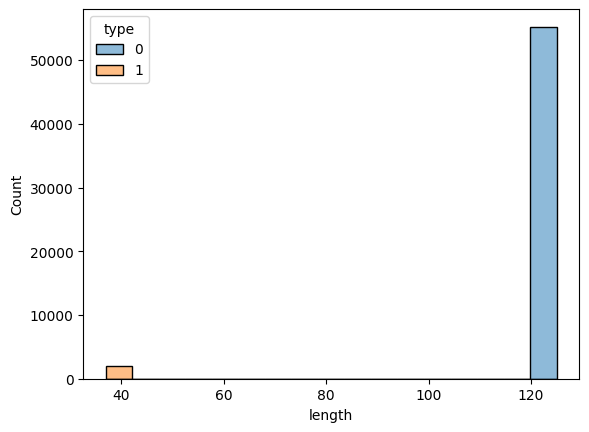

In [44]:
df = pd.DataFrame()
df['type'] = pd.Series(data[0])
df['length'] = pd.Series(data[1])
sns.histplot(df,x = 'length', hue = 'type')

In [45]:
def process_header(line):
    part1,part2,part3,empty = line.split(',')

    return {
        'id_string': part1,
        'basin': part1[:2],
        'cyc_num_year': int(part1[2:4]),
        'year': int(part1[4:8]),
        'name': part2.replace(' ',''),
        'rows': int(part3)
    }

def process_motion(line):
    spaces = line.split(',')
    return {
        'year': int(spaces[0][:4]),
        'month': int(spaces[0][4:6]),
        'day': int(spaces[0][6:8]),
        'hours':  int(spaces[1][1:3]),
        'minutes': int(spaces[1][3:5]),
        'record_id': spaces[2].replace(' ',''),
        'status': spaces[3].replace(' ',''),
        'latitude_N': float(spaces[4][:-1]),
        'longitude_E': float(spaces[5][:-1]) * (-1 if spaces[5][-1] == 'W' else -1),
        'max_wind': float(spaces[6]),
        'max_pressure': float(spaces[7]),
        '34kt': [float(space) for space in spaces[8:12]],
        '50kt': [float(space) for space in spaces[12:16]],
        '64kt': [float(space) for space in spaces[16:20]]
    }

process_motion(lines[1])

{'year': 1851,
 'month': 6,
 'day': 25,
 'hours': 0,
 'minutes': 0,
 'record_id': '',
 'status': 'HU',
 'latitude_N': 28.0,
 'longitude_E': -94.8,
 'max_wind': 80.0,
 'max_pressure': -999.0,
 '34kt': [-999.0, -999.0, -999.0, -999.0],
 '50kt': [-999.0, -999.0, -999.0, -999.0],
 '64kt': [-999.0, -999.0, -999.0, -999.0]}

In [46]:
datah = []
datam = []
datal = []
datals = []
current_storm = ''
new_storm = False
last_point = None
for line in lines:
    if(is_header_line(line)):
        dp = process_header(line)
        current_storm = dp['id_string']
        datah.append(dp)
        new_storm = True
    else:
        dp = process_motion(line)
        dp['storm_id'] = current_storm
        datam.append(dp)
        if not new_storm:
            datal.append(LineString([(last_point['longitude_E'],last_point['latitude_N']), (dp['longitude_E'], dp['latitude_N'])]))
            datals.append(current_storm)
        last_point = dp
        new_storm = False


dfh = pd.DataFrame(datah)
dfm = pd.DataFrame(datam)
dfl = gpd.GeoDataFrame(
    {'id': range(len(datal))},
    geometry= datal
)
dfl['storm_id'] = pd.Series(datals)

dfl = dfl.set_crs(epsg=4326)

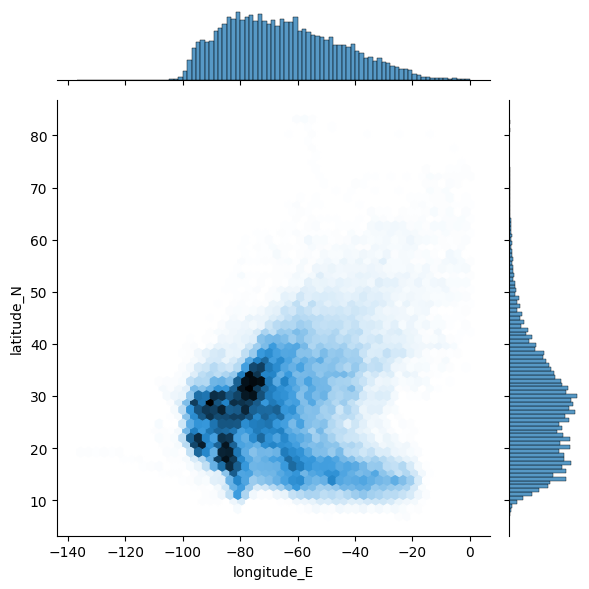

In [47]:
sns.jointplot(dfm,y='latitude_N',x='longitude_E',kind='hex')
plt.tight_layout()

In [11]:
gdf = gpd.read_file('Florida_Shoreline.geojson')

# Print the first few rows to inspect the data
gdf.head()

   OBJECTID last_edited_date     SHAPE_Area  SHAPE_Length  \
0         1             None   51857.830885   1316.397973   
1         2             None  325846.101689   3142.400186   
2         3             None    4539.989451    277.314723   
3         4             None    1233.021120    132.198061   
4         5             None  190803.363731   1930.662843   

                                            geometry  
0  POLYGON ((-81.96357 24.52436, -81.96352 24.524...  
1  POLYGON ((-81.97077 24.52704, -81.97079 24.527...  
2  POLYGON ((-81.92254 24.52898, -81.9224 24.5290...  
3  POLYGON ((-81.92284 24.52968, -81.92269 24.529...  
4  POLYGON ((-81.92643 24.53069, -81.92656 24.530...  


<Axes: xlabel='longitude_E', ylabel='latitude_N'>

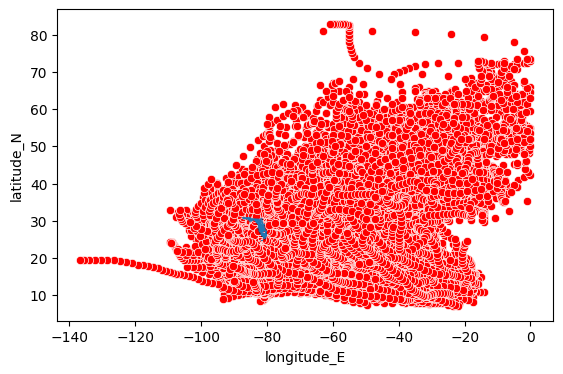

In [71]:
fig, ax = plt.subplots()

sns.scatterplot(dfm,y='latitude_N',x='longitude_E',color = 'red',ax=ax)
gdf.plot(ax=ax)

In [83]:
dfm['close_to_florida'] = (dfm['longitude_E'] < -79) & (dfm['longitude_E'] >-88) & (dfm['latitude_N'] > 24) & ( dfm['latitude_N'] <32.5)

(3468, 16)


<Axes: xlabel='longitude_E', ylabel='latitude_N'>

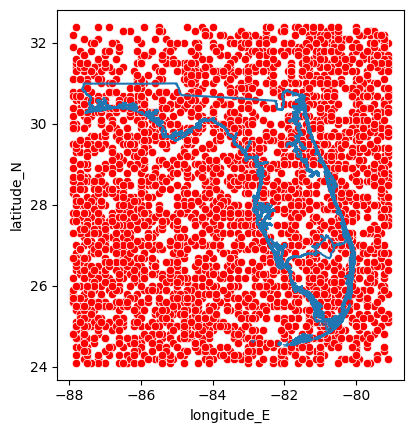

In [85]:
subdata = dfm[dfm['close_to_florida']]
print(subdata.shape)

fig, ax = plt.subplots()

sns.scatterplot(subdata,y='latitude_N',x='longitude_E',color = 'red',ax=ax)
gdf.boundary.plot(ax=ax)

In [25]:
type(dfl.crs)

pyproj.crs.crs.CRS

In [26]:
merged_florida = gdf.unary_union

C:\Users\benjr\AppData\Local\Temp\ipykernel_4416\2662847506.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  merged_florida = gdf.unary_union


In [27]:
merged_gdf = gpd.GeoDataFrame(
    [1],  # Dummy data for the index or ID column
    geometry=[merged_florida],
    crs=gdf.crs # It's crucial to preserve the original CRS
)

In [78]:
crosses_florida = dfl.crosses(merged_florida)
dfl['crosses'] = crosses_florida
dfl.head()

,id,geometry,storm_id,intersects,angle,crosses
0,0,"LINESTRING (-94.8 28, -95.4 28)",AL011851,False,3.141593,False
1,1,"LINESTRING (-95.4 28, -96 28)",AL011851,False,3.141593,False
2,2,"LINESTRING (-96 28, -96.5 28.1)",AL011851,False,2.944197,False
3,3,"LINESTRING (-96.5 28.1, -96.8 28.2)",AL011851,False,2.819842,False
4,4,"LINESTRING (-96.8 28.2, -97 28.2)",AL011851,False,3.141593,False


In [82]:
res = dfl.intersection(merged_florida)

KeyboardInterrupt: 

C:\Users\benjr\AppData\Local\Temp\ipykernel_4416\3732558971.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  florida_two = gdf.unary_union


ValueError: aspect must be finite and positive 

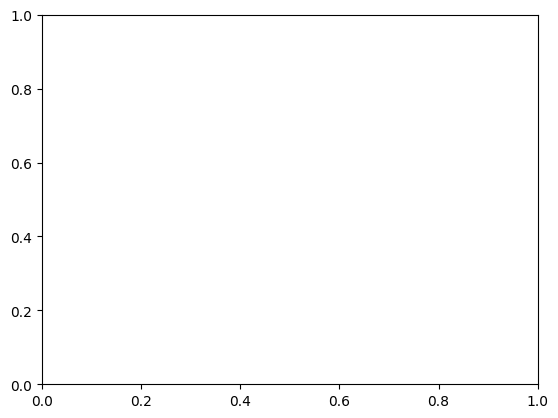

In [85]:
gdf = gpd.read_file('Florida_2.geojson')
florida_two = gdf.unary_union
gdf.boundary.plot()

In [87]:
gdf.head()

,FID,FeatureId,DATA_DATE,DATA_SRCE,PID,NAME,HT_MOD,CORS_ID,PACS_SACS,STATE,...,STABILITY,FIRST_RECV,LAST_RECV,LAST_COND,LAST_RECBY,SAT_USE,MARKER,SETTING,STAMPING,geometry
0,1,0,20210919,http://www.ngs.noaa.gov/cgi-bin/ds_mark.prl?Pi...,DO9740,17644 A,,,,FL,...,B,20130111,20130111,MONUMENTED,FLDEP,Y,DD = SURVEY DISK,50 = ALUMINUM ALLOY ROD W/O SLEEVE (10 FT.+),17644 A 2013,POINT (-81.73828 28.08614)
1,2,0,20210919,http://www.ngs.noaa.gov/cgi-bin/ds_mark.prl?Pi...,DO9741,17644 B,,,,FL,...,D,20130110,20130110,MONUMENTED,FLDEP,N,DD = SURVEY DISK,31 = SET IN A PAVEMENT SUCH AS STREET,SIDEWALK,POINT (-81.73811 28.08614)
2,3,0,20210919,http://www.ngs.noaa.gov/cgi-bin/ds_mark.prl?Pi...,DO9709,17646 A,,,,FL,...,B,20121221,20121221,MONUMENTED,FLDEP,N,DD = SURVEY DISK,50 = ALUMINUM ALLOY ROD W/O SLEEVE (10 FT.+),17646 A 2012,POINT (-81.74028 28.12201)
3,4,0,20210919,http://www.ngs.noaa.gov/cgi-bin/ds_mark.prl?Pi...,DO9710,17646 B,,,,FL,...,B,20121221,20121221,MONUMENTED,FLDEP,Y,DD = SURVEY DISK,50 = ALUMINUM ALLOY ROD W/O SLEEVE (10 FT.+),17646 B 2012,POINT (-81.74017 28.12176)
4,5,0,20210919,http://www.ngs.noaa.gov/cgi-bin/ds_mark.prl?Pi...,DO9711,17647 A,,,,FL,...,B,20121220,20121220,MONUMENTED,FLDEP,Y,DD = SURVEY DISK,50 = ALUMINUM ALLOY ROD W/O SLEEVE (10 FT.+),17647 A 2012,POINT (-81.73234 28.11284)


Text(0.5, 1.0, "Lines that don't cross Florida")

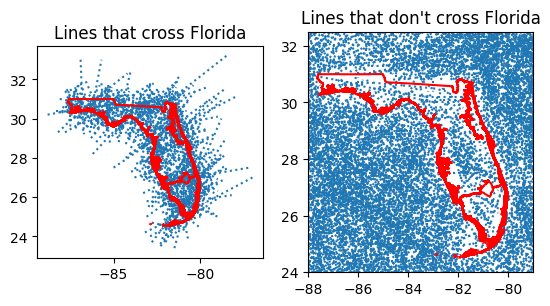

In [80]:
fig, ax = plt.subplots(1,2)

intersecting_storms = dfl[crosses_florida]
intersecting_storms.plot(ax=ax[0],linestyle = 'dotted')
gdf.boundary.plot(ax=ax[0],color='red')

non_intersecting_storms = dfl[dfl['crosses'] == False]
non_intersecting_storms.plot(ax=ax[1],linestyle = 'dotted')
gdf.boundary.plot(ax=ax[1],color='red')
ax[1].set_xlim([-88,-79])
ax[1].set_ylim([24,32.5])

ax[0].set_title("Lines that cross Florida")
ax[1].set_title("Lines that don't cross Florida")

In [71]:
x1 = dfl.geometry.apply(lambda geom: geom.coords[0][0])
y1 = dfl.geometry.apply(lambda geom: geom.coords[0][1])
x2 = dfl.geometry.apply(lambda geom: geom.coords[1][0])
y2 = dfl.geometry.apply(lambda geom: geom.coords[1][1])
dfl['angle'] = np.arctan2((y2-y1),(x2-x1))

<Axes: xlabel='angle', ylabel='Count'>

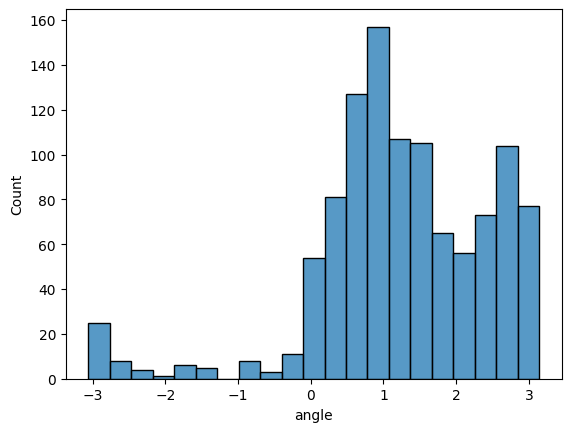

In [76]:
sns.histplot(dfl[dfl['intersects']],x='angle')

In [60]:
start_lon,start_lat = dfl.geometry.apply(lambda geom: geom.coords[0])
end_lon,end_lat = dfl.geometry.apply(lambda geom: geom.coords[1])
math.atan2((start_lat - end_lat)/(start_lon/end_lon))

ValueError: too many values to unpack (expected 2)

In [54]:
dfl.head()

,id,geometry,storm_id,intersects
0,0,"LINESTRING (-94.8 28, -95.4 28)",AL011851,False
1,1,"LINESTRING (-95.4 28, -96 28)",AL011851,False
2,2,"LINESTRING (-96 28, -96.5 28.1)",AL011851,False
3,3,"LINESTRING (-96.5 28.1, -96.8 28.2)",AL011851,False
4,4,"LINESTRING (-96.8 28.2, -97 28.2)",AL011851,False


<Axes: >

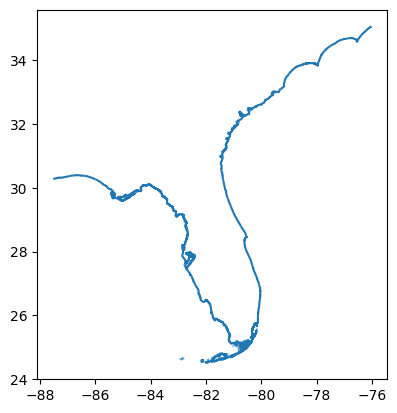

In [526]:
gpdus = gpd.read_file('tl_2019_us_coastline.shp')
#Find here: https://catalog.data.gov/dataset/tiger-line-shapefile-2019-nation-u-s-coastline-national-shapefile

x1 = gpdus.geometry.apply(lambda geom: geom.coords[0][0])
y1 = gpdus.geometry.apply(lambda geom: geom.coords[0][1])
x2 = gpdus.geometry.apply(lambda geom: geom.coords[1][0])
y2 = gpdus.geometry.apply(lambda geom: geom.coords[1][1])

in_range = ((-88 < x1) & (x1 < -70)) & ((24 < y1) & (y1 < 35))
east_coast = gpdus[in_range]
east_coast = east_coast[east_coast.geometry.apply(lambda geom: geom.is_closed == False)]
east_coast = east_coast.reset_index()
gpdus[in_range].plot()

<Axes: >

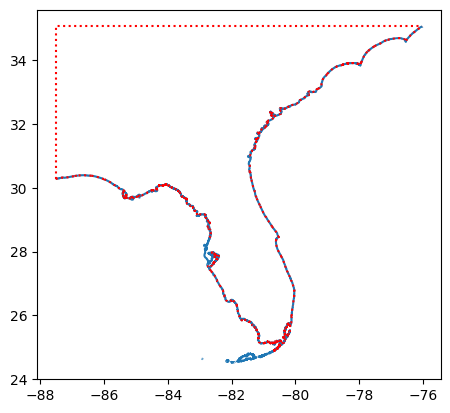

In [530]:
fig,ax=plt.subplots()

east_coast.plot(ax=ax)
cleared.plot(ax=ax,linestyle = 'dotted',color = 'red')

In [486]:
x1 = east_coast.geometry.apply(lambda geom: geom.coords[0][0])
y1 = east_coast.geometry.apply(lambda geom: geom.coords[0][1])
x2 = east_coast.geometry.apply(lambda geom: geom.coords[-1][0])
y2 = east_coast.geometry.apply(lambda geom: geom.coords[-1][1])

print(min(x1))
print(min(x2))

print(max(x1))
print(max(x2))

x = min(x1)
y = east_coast[east_coast.geometry.apply(lambda geom: geom.coords[0][0] == min(x1))].geometry.apply(lambda geom: geom.coords[0][1])
a = (x,y.iloc[0])
x = max(x2)
y = east_coast[east_coast.geometry.apply(lambda geom: geom.coords[-1][0] == max(x2))].geometry.apply(lambda geom: geom.coords[-1][1])
b = (x,y.iloc[0])
c = (min(x1),y)

-87.51832499999999
-86.919291
-77.10835999999999
-76.01324999999999


C:\Users\benjr\AppData\Local\Programs\Python\Python310\lib\site-packages\shapely\geometry\linestring.py:67: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(c) for c in o]


<Axes: >

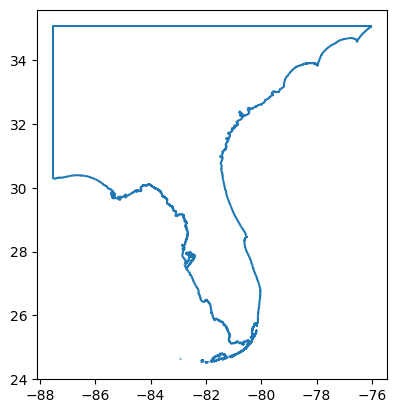

In [487]:
new_geometry = east_coast.geometry
new_series = gpd.GeoSeries( [LineString([a,c,b])] ).set_crs(east_coast.crs)
east_coast = pd.concat([new_geometry, new_series])
#east_coast = east_coast.make_valid()
east_coast=east_coast.reset_index(drop=True)
east_coast.plot()

In [488]:
# Create an R-tree spatial index
idx = index.Index()

# Insert the geometries into the spatial index
for i, geometry in enumerate(east_coast.geometry):
    # Insert bounding box coordinates of the geometry into the R-tree
    idx.insert(i, geometry.bounds)

# Create a list to store connected LineStrings
connected_pairs = []

# Loop through each LineString and use the spatial index to find nearby LineStrings
for i, line1 in enumerate(east_coast.geometry):
    # Get the bounding box of the current LineString
    bbox1 = line1.bounds
    # Find nearby LineStrings using the spatial index
    possible_neighbors = list(idx.intersection(bbox1))

    for j in possible_neighbors:
        # Skip if it's the same LineString
        if i == j:
            continue
        
        line2 = east_coast.geometry.iloc[j]
        
        # Check if line1 and line2 are actually connected
        if line1.touches(line2):
            connected_pairs.append((i, j))

In [490]:
def get_loops(connected_pairs):
    loops = {}
    keys = {}
    loopno = 0
    
    for pair in connected_pairs:
        x,y = pair
        if(x not in loops) & (y not in loops):
            loops[x] = loopno
            loops[y] = loopno
            keys[loopno] = [x,y]
            loopno = loopno + 1
        elif(x in loops) & (y not in loops):
            loops[y] = loops[x]
            keys[loops[x]].append(y)
        elif(x not in loops) & (y in loops):
            loops[x] = loops[y]
            keys[loops[y]].append(x)
        else:
            if(loops[x] != loops[y]):
                #Merge loops
                old_loop = loops[y]
                keys[loops[x]] = keys[loops[x]] + keys[loops[y]]
                for i in keys[old_loop]:
                    loops[i] = loops[x]
                keys[old_loop] = None
    return {k: v for k, v in keys.items() if v is not None}

In [512]:
def build_chain(nums, connected_pairs):
    links = defaultdict(lambda: [None, None])
    
    nums_set = set(nums)
    connected_pairs = [pair for pair in connected_pairs if pair[0] in nums_set]

    for x,y in connected_pairs:
        if links[x][0] != None:
            if(y != links[x][0]):
                links[x][1] = y
        else:
            links[x][0] = y
        if links[y][0] != None:
            if(x != links[y][0]):
                links[y][1] = x
        else:
            links[y][0] = x
    data = [i for i in nums_set if links[i][1] == None]
    i=0
    chain = [None] * len(nums_set)
    next_num = data[0]
    while(next_num != None):
        chain[i] = next_num
        next_num = links[next_num][0] if links[next_num][0] not in chain else links[next_num][1]
        if(i>100):
            next_num = None
            print('bad')
        i=i+1
    return chain

mls = []
indices = list(loops.keys())
for i in indices:
    loops = get_loops(connected_pairs)
    chain = build_chain(loops[i],connected_pairs)
    closed = east_coast[chain[0]].touches(east_coast[chain[-1]])
    if not closed:
        mls.append(shapely.MultiLineString([east_coast[chain[j]] for j in range(len(chain))]))

<Axes: >

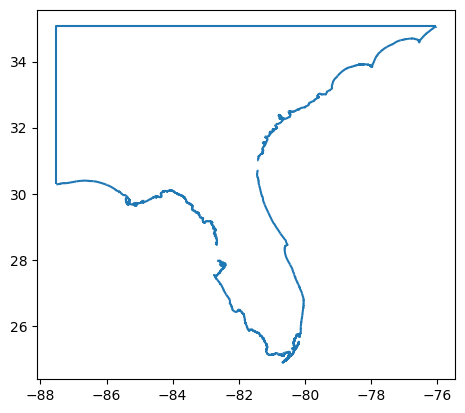

In [525]:
cleared = gpd.GeoSeries(mls)
cleared.plot()

In [329]:
a=list(keys.keys())
len(a)

27

<Axes: >

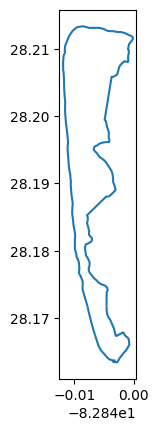

In [327]:
in_part = pd.Series([j in keys[40] for j in range(170)])
east_coast[in_part].plot()

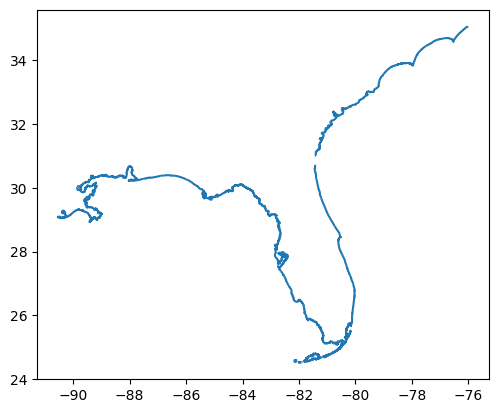

In [242]:
fig, ax = plt.subplots()

colors = ['red','blue','green','orange','purple']
for i in range(len(a)):
    in_part = pd.Series([j in keys[a[i]] for j in range(170)])
    east_coast[in_part].plot(ax=ax)

In [167]:
east_coast['length'] =east_coast.geometry.apply(lambda geom: geom.length)
east_coast['closed'] =east_coast.geometry.apply(lambda geom: geom.is_closed)

C:\Users\benjr\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\benjr\AppData\Local\Programs\Python\Python310\lib\site-packages\geopandas\geodataframe.py:1968: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [169]:
east_coast = east_coast[east_coast['closed'] == False]

<Axes: xlabel='length', ylabel='Count'>

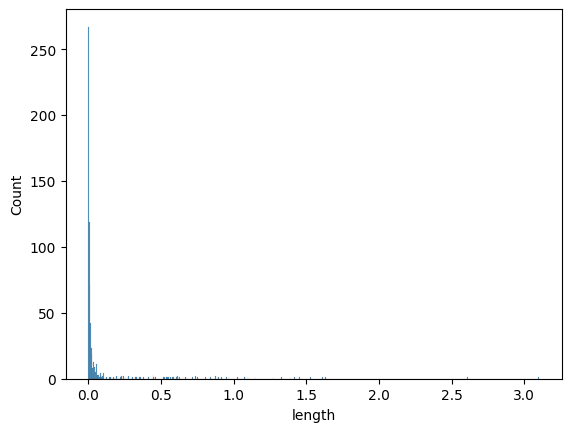

In [112]:
sns.histplot(east_coast,x='length')

,index,length
count,75.000000,75.000000
mean,143.826667,0.672560
std,136.830668,0.536961
min,0.000000,0.103591
25%,23.500000,0.316832
50%,168.000000,0.541133
75%,194.500000,0.877446
max,658.000000,3.102158


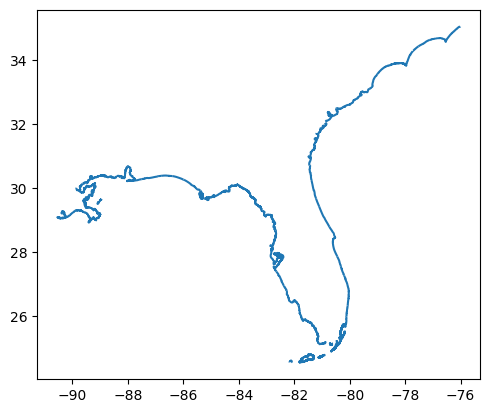

In [122]:
east_coast = east_coast[(east_coast['closed']== False) & (east_coast['length']> 0.1)]
east_coast.plot()
east_coast.describe()

TypeError: 'MultiPoint' object is not subscriptable

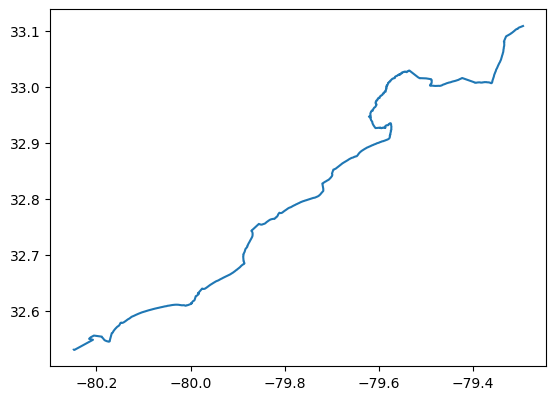

In [160]:
east_coast.geometry[0:1].plot()

In [147]:
def connect_to_nearest(g,multipoint):
    starting_point = Point(g.coords[0])
    return nearest_points(g, multipoint)

ne = LineString([(0, 0), (1, 1), (2, 2)])

# Create the new point to add
new_point = Point(3, 3)

# Get the coordinates of the original LineString
original_coords = list(line.coords)

# Get the coordinates of the new point
new_point_coords = list(new_point.coords)

# Combine the coordinates
combined_coords = original_coords + new_point_coords

# Create a new LineString from the combined coordinates
new_line = LineString(combined_coords)

print(f"Original LineString: {line}")
print(f"New LineString: {new_line}")

ending = MultiPoint(east_coast.geometry.apply(lambda g: g.coords[-1]))
east_coast.geometry.apply(lambda g: connect_to_nearest(g,ending))

0      (POINT (-79.29192999999998 33.10898699999999),...
1      (POINT (-76.01324999999999 35.06198299999999),...
2      (POINT (-78.54201799999998 33.851932999999995)...
3      (POINT (-77.71433199999998 34.291167), POINT (...
5      (POINT (-79.29192999999998 33.10898699999999),...
                             ...                        
328    (POINT (-84.355226 29.963054999999997), POINT ...
365    (POINT (-89.044494 29.56620799999999), POINT (...
645    (POINT (-82.11344599999998 24.551466999999988)...
650    (POINT (-81.81253599999998 24.545469), POINT (...
658    (POINT (-81.12476099999999 24.707128999999988)...
Name: geometry, Length: 75, dtype: object

<Axes: >

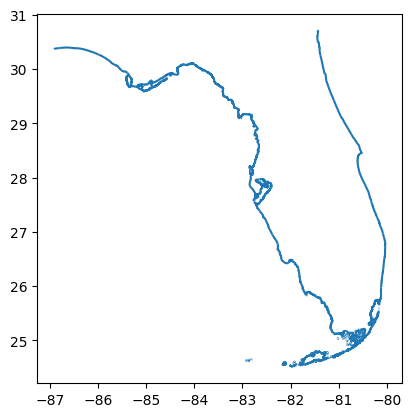

In [38]:
in_range = ((-87.4 < x1) & (x1 < -79)) & ((24 < y1) & (y1 < 30.7))
florida_coast = gpdus[in_range]
gpdus[in_range].plot()

In [40]:
florida_coast.to_file("florida_coast.geojson", driver="GeoJSON")

In [50]:
florida_coast.head()

,NAME,MTFCC,geometry
357,Atlantic,L4150,"LINESTRING (-80.66551 24.89496, -80.66551 24.8..."
358,Atlantic,L4150,"LINESTRING (-80.24605 25.34069, -80.247 25.341..."
359,Atlantic,L4150,"LINESTRING (-80.37687 25.30586, -80.37723 25.3..."
360,Atlantic,L4150,"LINESTRING (-80.24977 25.34176, -80.24977 25.3..."
361,Atlantic,L4150,"LINESTRING (-80.37687 25.30586, -80.37666 25.3..."


In [51]:
dfl.head()

,id,geometry,storm_id,crosses
0,0,"LINESTRING (-94.8 28, -95.4 28)",AL011851,False
1,1,"LINESTRING (-95.4 28, -96 28)",AL011851,False
2,2,"LINESTRING (-96 28, -96.5 28.1)",AL011851,False
3,3,"LINESTRING (-96.5 28.1, -96.8 28.2)",AL011851,False
4,4,"LINESTRING (-96.8 28.2, -97 28.2)",AL011851,False


C:\Users\benjr\AppData\Local\Temp\ipykernel_7224\1649295071.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  crosses_florida = dfl.intersects(florida_coast.unary_union)


Text(0.5, 1.0, "Lines that don't cross Florida Coast")

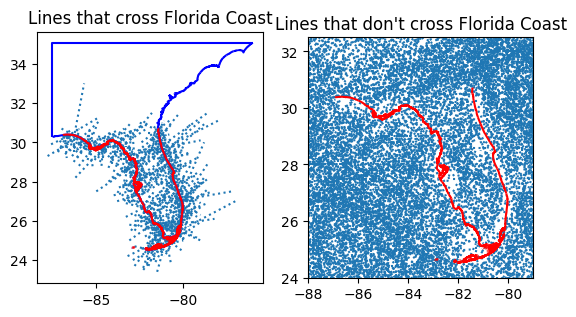

In [300]:
crosses_florida = dfl.intersects(florida_coast.unary_union)
dfl['crosses'] = crosses_florida
dfl.head()

fig, ax = plt.subplots(1,2)

intersecting_storms = dfl[crosses_florida]
intersecting_storms.plot(ax=ax[0],linestyle = 'dotted')
east_coast.plot(ax=ax[0],color='blue')
florida_coast.plot(ax=ax[0],color='red')

non_intersecting_storms = dfl[dfl['crosses'] == False]
non_intersecting_storms.plot(ax=ax[1],linestyle = 'dotted')
florida_coast.plot(ax=ax[1],color='red')
ax[1].set_xlim([-88,-79])
ax[1].set_ylim([24,32.5])

ax[0].set_title("Lines that cross Florida Coast")
ax[1].set_title("Lines that don't cross Florida Coast")